In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import time
import importlib

from art.attacks import FastGradientMethod, ProjectedGradientDescent, CarliniL2Method
from art.classifiers import PyTorchClassifier

# Hyper Parameters
EPOCH = 20
BATCH_SIZE = 256
LR = .5  # learning rate
MNT = 0.9   # momentum variable
DOWNLOAD_Dataset = True
N_TEST_IMG = 5
m = 1024     # Dictionary Size

# parameter settings:
# m     lambda    eta
# 100   .2        .1
# 200

# torch.cuda.set_device(1)
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [2]:
data_dir = 'data/'

def get_data_loaders(data_dir,BSize):
    
    train_data = torchvision.datasets.CIFAR10(
        root= data_dir,
        train=True,                                     # this is training data
        transform=torchvision.transforms.Compose([torchvision.transforms.RandomCrop(32, padding=4),
                                                  torchvision.transforms.ToTensor(),
                                  torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                                 ]),    
        download=DOWNLOAD_Dataset,                        # download it if you don't have it
    )
    # Data Loader for easy mini-batch return in training, the image batch shape will be (50, 1, 28, 28)
    train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BSize, shuffle=True)

    test_data = torchvision.datasets.CIFAR10(
        root= data_dir,
        train=False,                                     # this is testing data
        transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                  torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                                 ]),
        download=DOWNLOAD_Dataset,                        # download it if you don't have it
    )
    test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=BSize, shuffle=True)
    
    return train_loader, test_loader


def preprocess(x):
    x = x.view(-1, 32*32*3).t()
    ms = torch.mean(x,dim=0)
    x = x - ms
    x = modelDL.NormDict(x).t()
    return x
    

In [3]:
import sparse_learnable_dictionary as modelDL

train_loader, test_loader = get_data_loaders(data_dir,BATCH_SIZE)


Files already downloaded and verified
Files already downloaded and verified


### First unsupervised training

In [4]:
import importlib
importlib.reload(modelDL)

# Training
Error = np.zeros((EPOCH,))
Nnz = np.zeros((EPOCH,))
Loss = np.zeros((EPOCH,))
N = len(train_loader.dataset)
DISPLAY_FREQ = 1 ;
TSHOW = np.round(DISPLAY_FREQ * N/BATCH_SIZE) # times per EPOCH to display information
t0 = time.perf_counter()
SC = 'fista' # 'fista' or 'IHT'
lambd = .02       # sparsity parameter: float numer if 'fista' or cardinality constraint if 'IHT'

model = modelDL.DictLearnCIFAR(m,SC,lambd).to(device)
# optimizer = torch.optim.SGD(model.parameters(), lr=.001, momentum=.9)
optimizer = torch.optim.Adam(model.parameters())
loss_func = nn.MSELoss()

Err = []

In [5]:
# model.double()
I = torch.Tensor(np.eye(m)).type(model.W.type()).to(device)

for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):
        b_x = preprocess(x).to(device).type(model.W.type())  # batch x, shape (batch, 28*28)
        b_y = preprocess(x).to(device).type(model.W.type())     # batch y, shape (batch, 28*28)
        b_label = (y).to(device)               # batch label

        decoded, encoded, errIHT = model(b_x)
        
        loss = loss_func(decoded, b_y) + .00001 * torch.norm(I - torch.matmul(model.W.t() , model.W))**2
#         loss = 1/len(b_label) * torch.norm(b_x-b_y)**2
        optimizer.zero_grad()               # clear gradients for this training step
        loss.backward()                     # backpropagation, compute gradients
        optimizer.step()                    # apply gradients
        model.zero_grad()
        model.normalize()
        
        
        if SC == 'IHT': Loss[epoch] = Loss[epoch] + loss.data
        elif SC == 'fista': Loss[epoch] = Loss[epoch] + loss.data + lambd * np.sum(np.abs(encoded.detach().cpu().numpy()))
        
        decoded = decoded.detach()
        err = np.linalg.norm( (decoded-b_x).cpu().numpy() ,'fro') / np.linalg.norm( b_x.cpu().numpy() ,'fro')
        Error[epoch] = Error[epoch] + errIHT[-1]
        Err = np.append(Err,errIHT[-1])
        Nnz[epoch] = Nnz[epoch] + np.count_nonzero(encoded.detach().cpu().numpy())/encoded.detach().cpu().numpy().size
#         print('Density: %.3f' % (np.count_nonzero(encoded.detach().cpu().numpy())/ BATCH_SIZE))
        
#         # for debugging:
#         print(Error[epoch]/(step+1))
#         if step%50==0:
#             plt.plot(errIHT); plt.show()
        
    Loss[epoch] /= len(train_loader.dataset)
    Error[epoch] /= (step+1)
    Nnz[epoch] /= (step+1)
    print('Epoch: ', epoch, ', Error: ', Error[epoch], ', | train loss: %.3e' % Loss[epoch], ' NNZ/sample: ', Nnz[epoch] )
    

model_unsup = model

Epoch:  0 , Error:  0.6113164809589483 , | train loss: 9.333e-02  NNZ/sample:  0.2268811868161571
Epoch:  1 , Error:  0.45414152285274195 , | train loss: 7.855e-02  NNZ/sample:  0.11043256642867108
Epoch:  2 , Error:  0.40925400035113707 , | train loss: 7.740e-02  NNZ/sample:  0.08590400462247888
Epoch:  3 , Error:  0.38814471844507725 , | train loss: 7.725e-02  NNZ/sample:  0.07954658196896923
Epoch:  4 , Error:  0.3751363667602442 , | train loss: 7.707e-02  NNZ/sample:  0.07702985101816606
Epoch:  5 , Error:  0.36693934822569085 , | train loss: 7.690e-02  NNZ/sample:  0.07605697476134009
Epoch:  6 , Error:  0.3616276637327914 , | train loss: 7.695e-02  NNZ/sample:  0.07597324994145607
Epoch:  7 , Error:  0.35775818280419525 , | train loss: 7.712e-02  NNZ/sample:  0.07645516298255142
Epoch:  8 , Error:  0.35508701342101 , | train loss: 7.749e-02  NNZ/sample:  0.07730679803965043
Epoch:  9 , Error:  0.35247843134768153 , | train loss: 7.780e-02  NNZ/sample:  0.07803239627760283
Epoch: 

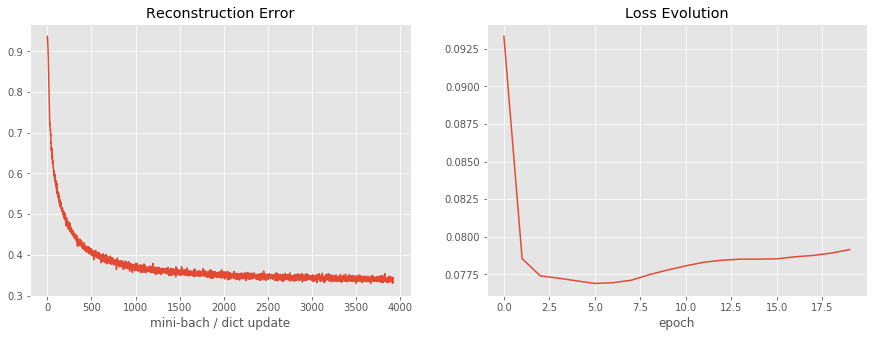

In [6]:
plt.style.use('ggplot')

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(Err); plt.title('Reconstruction Error'); plt.xlabel('mini-bach / dict update');
plt.subplot(1,2,2)
plt.plot(Loss); plt.title('Loss Evolution'); plt.xlabel('epoch')
plt.show(); 

from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
    
# W = model_unsup.cpu().W.data.numpy().copy()
# nat = int(np.floor(np.sqrt(m)))
# M1 = modelDL.showFilters(W,nat,nat)
# plt.figure(figsize=(10,10))
# plt.imshow(rescale(M1,4,mode='constant'),cmap='gray')
# plt.axis('off')
# plt.show()

Analizing Encoder Gap

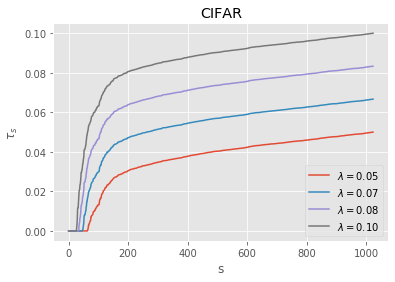

In [7]:
importlib.reload(modelDL)

model.learn_flag = False
model.FistaIter = 100

(x, y) = next(iter(test_loader))
b_x = preprocess(x).to(device).type(model.W.type())

mus = modelDL.get_babel(model)
Max_S = torch.sum(mus<1)

model.to(device)
LMDS = torch.linspace(0.05,.1,4).to(device)

plt.style.use('ggplot')
plt.figure()
for i in range(len(LMDS)):
    model.lambd = nn.Parameter(LMDS[i])
    _,projs = modelDL.get_encoderGap(model,b_x,1)
    plt.plot(projs.cpu().numpy(),label=r'$\lambda =$%.2f'%LMDS[i].cpu().numpy())

plt.xlabel('s')
plt.ylabel(r'$\tau_s$')
plt.title('CIFAR')
plt.legend()
plt.savefig('encoder_gap_cifar_unsupervised.pdf',transparent = True,dpi = 100)
plt.show()

### Supervised Training

In [8]:
# Initialize
importlib.reload(modelDL)

BATCH_SIZE = 256
SC = 'fista' # 'fista' or 'IHT'
LMDS = torch.Tensor([.1, .1, .1]).to(device)/5
EPOCH = 50
FISTA_ITER = 100

train_loader, test_loader = get_data_loaders(data_dir,BATCH_SIZE)

model = modelDL.DictLearn_supervised_CIFAR(m,SC,Fiter = FISTA_ITER).to(device)
optimizer = torch.optim.Adam(model.parameters())
# optimizer = torch.optim.LBFGS(model.parameters())
# optimizer = torch.optim.SGD(model.parameters(), lr=.01, momentum=.9)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=.2)
# optimizer = torch.optim.SGD([
# 	{'params': model.W.parameters(), 'lr': 0.0}], lr=0.01, momentum=0.9, nesterov=True)


loss_func = nn.CrossEntropyLoss()

Using_Unsupervised_Dictionary_as_Init = True


if Using_Unsupervised_Dictionary_as_Init:
    model.init_dictionary(model_unsup.W)

# model.only_linear_training_on()

    
Loss_sup = []
accuracy_train = []
accuracy_test = []
nnz = []

eta1 = 0#50
eta2 = 0#.3

import time

Files already downloaded and verified
Files already downloaded and verified


In [9]:
I = torch.Tensor(np.eye(m)).type(model.W.type()).to(device)

# settings things up
model.learn_flag = True
model.float().to(device)

for epoch in range(EPOCH):
    
    model.lambd = nn.Parameter(LMDS[min(epoch,len(LMDS)-1)])
    
    for step, (x, y) in enumerate(train_loader):
        b_x = preprocess(x).to(device).type(model.W.type())
        b_label = (y).to(device)            # batch label

        out = model(b_x)
        
        Lclass = loss_func(out, b_label)
        Ldict = 1/m * torch.norm(I - torch.matmul(model.W.t() , model.W))**2
        Lw = 1/m * torch.norm(model.Wclass.weight)**2
        loss = Lclass + eta1*Ldict  + eta2*Lw 
        
        optimizer.zero_grad()               # clear gradients for this training step
        loss.backward()                     # backpropagation, compute gradients
        optimizer.step()                    # apply gradients
        model.zero_grad()
        model.normalize()
        
        Loss_sup = np.append(Loss_sup,loss.data)
        acc = torch.sum(torch.argmax(out, dim=1) == b_label).cpu().numpy() / len(b_label)
        accuracy_train = np.append(accuracy_train,acc)
        nnz = np.append(nnz,model.last_avg_nnz)
        
        if step % 10 == 0: # validate accuracy
            t = time.time()
            acc = 0
            for cnt, (x, y) in enumerate(test_loader):
                b_x = preprocess(x).to(device).type(model.W.type())
                b_label = (y).to(device)           # batch label

                out = model(b_x)

                acc += torch.sum(torch.argmax(out, dim=1) == b_label).cpu().numpy()
            
            elapsed = time.time() - t
            accuracy_test = np.append(accuracy_test,acc / len(test_loader.dataset))
            print('Epc/stp: %d/%d'%(epoch+1,step),'| Lmd = %.2f'%model.lambd,'| Loss: %.3f'%np.mean(Loss_sup[-20:-1]),
                  ' | nnz: %.2f' % nnz[-1],'| train acc.: %.2f' % accuracy_train[-1] , '| test acc: %.2f' % accuracy_test[-1],
                  ' | mu: %.4f'% modelDL.get_mu(model),' | Cw: %.4f'% modelDL.get_ClassifierConstant(model),'| T/I = %.2f'%elapsed)
            model.accuracy_test = accuracy_test
            
    # to do every epoch:
    
#     scheduler.step()
            
# Done training - change to exact Lasso solution
model.learn_flag = False


/home/jere/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jere/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epc/stp: 1/0 | Lmd = 0.02 | Loss: nan  | nnz: 84.21 | train acc.: 0.11 | test acc: 0.15  | mu: 0.0365  | Cw: 0.8533 | T/I = 9.94
Epc/stp: 1/10 | Lmd = 0.02 | Loss: 2.299  | nnz: 97.74 | train acc.: 0.17 | test acc: 0.21  | mu: 0.1011  | Cw: 0.8651 | T/I = 9.67
Epc/stp: 1/20 | Lmd = 0.02 | Loss: 2.293  | nnz: 113.16 | train acc.: 0.21 | test acc: 0.25  | mu: 0.1608  | Cw: 0.9301 | T/I = 10.04
Epc/stp: 1/30 | Lmd = 0.02 | Loss: 2.280  | nnz: 125.33 | train acc.: 0.22 | test acc: 0.25  | mu: 0.1801  | Cw: 1.0592 | T/I = 9.86
Epc/stp: 1/40 | Lmd = 0.02 | Loss: 2.264  | nnz: 136.54 | train acc.: 0.23 | test acc: 0.26  | mu: 0.2623  | Cw: 1.2151 | T/I = 9.77
Epc/stp: 1/50 | Lmd = 0.02 | Loss: 2.247  | nnz: 141.30 | train acc.: 0.30 | test acc: 0.27  | mu: 0.2763  | Cw: 1.3986 | T/I = 9.76
Epc/stp: 1/60 | Lmd = 0.02 | Loss: 2.228  | nnz: 141.68 | train acc.: 0.26 | test acc: 0.27  | mu: 0.3017  | Cw: 1.6061 | T/I = 9.71
Epc/stp: 1/70 | Lmd = 0.02 | Loss: 2.215  | nnz: 138.19 | train acc.: 0.2

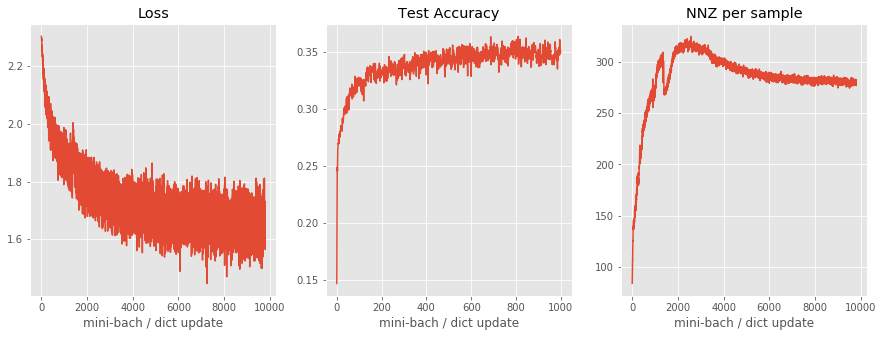

In [10]:
# torch.save(model.state_dict(), 'models/cifar_model_L03.tr')
model.lambd = nn.Parameter(LMDS[0])

# model.load_state_dict(torch.load('models/cifar_model_L03.tr'))

from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
    
plt.style.use('ggplot')

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(Loss_sup); plt.title('Loss'); plt.xlabel('mini-bach / dict update');
plt.subplot(1,3,2)
plt.plot(accuracy_test); plt.title('Test Accuracy'); plt.xlabel('mini-bach / dict update');
plt.subplot(1,3,3)
plt.plot(nnz); plt.title('NNZ per sample'); plt.xlabel('mini-bach / dict update');
plt.show()


Analizing Encoder Gap

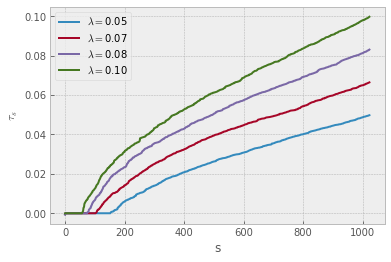

In [23]:
importlib.reload(modelDL)

model.learn_flag = False
model.FistaIter = 200

(x, y) = next(iter(test_loader))
b_x = preprocess(x).to(device).type(model.W.type())

mus = modelDL.get_babel(model)
Max_S = torch.sum(mus<1)

model.to(device)
LMDS = torch.linspace(0.05,.1,4).to(device)

plt.style.use('bmh')
plt.figure()
for i in range(len(LMDS)):
    model.lambd = nn.Parameter(LMDS[i])
    _,projs = modelDL.get_encoderGap(model,b_x,1)
    plt.plot(projs.cpu().numpy(),label=r'$\lambda =$%.2f'%LMDS[i].cpu().numpy())

plt.xlabel('s')
plt.ylabel(r'$\tau_s$')
# plt.title('CIFAR')
plt.legend()
plt.savefig('encoder_gap_cifar_supervised.pdf',transparent = True,dpi = 100)
plt.show()